# VGG Pytorch Implementation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Loading MNIST Dataset

In [3]:
transforms = T.Compose([
    T.ToTensor(),
    T.Pad(2)
])

In [4]:
mnist_train = torchvision.datasets.MNIST('./MNIST/MNIST_train/', train=True, download=True, transform=transforms)
mnist_test = torchvision.datasets.MNIST('./MNIST/MNIST_test/', train=False, download=True, transform=transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_train/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST_train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_train/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST_train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST_train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST_train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_test/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST_test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_test/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST_test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST_test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST_test/MNIST/raw



In [27]:
data_loader_train = DataLoader(mnist_train, batch_size=32, shuffle=True)
data_loader_test = DataLoader(mnist_test, batch_size=32)

In [6]:
def show_sample_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    img_grid = make_grid((images[:nmax]), nrow=8)
    ax.imshow(img_grid.permute(1, 2, 0))

9 - 9 - 4 - 5 - 6 - 1 - 3 - 6 - 6 - 7 - 7 - 6 - 8 - 1 - 9 - 0 - 9 - 6 - 8 - 8 - 8 - 3 - 1 - 2 - 4 - 5 - 3 - 0 - 2 - 7 - 4 - 1


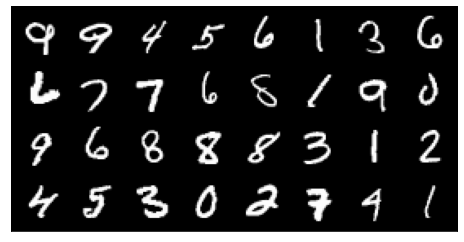

In [7]:
batch_X, batch_Y = iter(data_loader_train).next()
show_sample_images(batch_X, 32)
print(" - ".join(map(lambda x: str(x.item()), batch_Y)))

In [8]:
batch_X[0].shape

torch.Size([1, 32, 32])

### Models

In [9]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "VGG19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"]
}

In [10]:
class VGG(nn.Module):
    def __init__(self, vgg_type="VGG11", in_channels=1, num_classes=10):
        super(VGG, self).__init__()
        self.vgg_type = vgg_type
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv_layers = self.create_conv_layers()
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def create_conv_layers(self):
        layers = []
        in_channels = self.in_channels

        for layer_type in VGG_types[self.vgg_type]:
            if type(layer_type) == int:
                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=layer_type,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(layer_type),
                    nn.ReLU(),
                ]
                in_channels = layer_type
            elif layer_type == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
        
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_layers(x)
        return x

In [12]:
model = VGG("VGG11", in_channels=1, num_classes=10).to(device)
summary(model, input_size=(1, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

### Training

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [14]:
for epoch in range(2):
    print(f"Starting Epoch {epoch}")

    for batch_i, (X, Y) in enumerate(data_loader_train):
        X = X.to(device)
        Y = F.one_hot(Y, num_classes=10).float().to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if batch_i % 100 == 0:
            print(f"Training Loss: {loss.item()}")

Starting Epoch 0
Training Loss: 2.3830389976501465
Training Loss: 2.239379405975342
Training Loss: 1.988600730895996
Training Loss: 1.570544958114624
Training Loss: 1.3944872617721558
Training Loss: 1.1136523485183716
Training Loss: 0.7081966400146484
Training Loss: 0.29680654406547546
Training Loss: 0.3466074466705322
Training Loss: 0.176344096660614
Training Loss: 0.11916066706180573
Training Loss: 0.17441695928573608
Training Loss: 0.03168077394366264
Training Loss: 0.14816531538963318
Training Loss: 0.2960137724876404
Training Loss: 0.03821764886379242
Training Loss: 0.116806261241436
Training Loss: 0.40328216552734375
Training Loss: 0.01683199778199196
Starting Epoch 1
Training Loss: 0.08360506594181061
Training Loss: 0.5199164152145386
Training Loss: 0.17697954177856445
Training Loss: 0.07106246054172516
Training Loss: 0.02122960239648819
Training Loss: 0.03937720134854317
Training Loss: 0.05748207867145538
Training Loss: 0.25174427032470703
Training Loss: 0.001029724138788879
Tr

### Evaluation

Accuracy: 0.9740999937057495


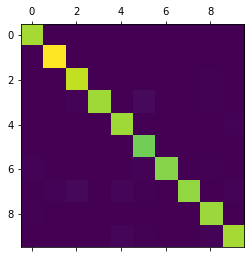

In [29]:
correct = 0
total = 0
confusion_matrix = [[0 for _ in range(10)] for _ in range(10)]

with torch.no_grad():
    for batch_i, (X, Y) in enumerate(data_loader_test):
        total += X.shape[0]
        
        X = X.to(device)
        Y = Y.to(device)
        outputs = torch.argmax(model(X), dim=1)
        correct += torch.sum(outputs == Y)

        for true, pred in zip(Y, outputs):
            confusion_matrix[true][pred] += 1
    
print(f"Accuracy: {correct / total}")
plt.matshow(confusion_matrix)